In [1]:
# input image
# detect text boxes
# detect text
# return text and positions

In [2]:
import sys
import os

from PIL import Image
import cv2
from matplotlib import pyplot as plt
%matplotlib inline
import time
from collections import OrderedDict
import numpy as np
import torch
import torchvision.transforms as transforms
from dotmap import DotMap

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

from craft import CRAFT
import imgproc
import craft_utils

from ocr_model import Model
from ocr_dataset import RawDataset, AlignCollate
from ocr_utils import CTCLabelConverter, AttnLabelConverter

In [3]:
def RepresentsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False
# end

def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict
# end

def init_craft():
     # load net
    net = CRAFT()     # initialize
    str_trained_model_path = 'dmodel/craft_mlt_25k.pth'
    net.load_state_dict(copyStateDict(torch.load(str_trained_model_path)))
    
    if True:
        net = net.cuda()
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = False

    net.eval()
    
    return net
# end

def test_net(net, image, text_threshold, link_threshold, low_text, cuda, canvas_size, show_time,mag_ratio):
    t0 = time.time()

    # resize
    img_resized, target_ratio, size_heatmap = imgproc.resize_aspect_ratio(image, canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=mag_ratio)
    ratio_h = ratio_w = 1 / target_ratio

    # preprocessing
    x = imgproc.normalizeMeanVariance(img_resized)
    x = torch.from_numpy(x).permute(2, 0, 1)    # [h, w, c] to [c, h, w]
    x = Variable(x.unsqueeze(0))                # [c, h, w] to [b, c, h, w]
    if cuda:
        x = x.cuda()

    # forward pass
    y, _ = net(x)

    # make score and link map
    score_text = y[0,:,:,0].cpu().data.numpy()
    score_link = y[0,:,:,1].cpu().data.numpy()

    t0 = time.time() - t0
    t1 = time.time()
    
    # Post-processing
    boxes = craft_utils.getDetBoxes(score_text, score_link, text_threshold, link_threshold, low_text)
    boxes = craft_utils.adjustResultCoordinates(boxes, ratio_w, ratio_h)

    t1 = time.time() - t1
    
    if show_time : print("\ninfer/postproc time : {:.3f}/{:.3f}".format(t0, t1))

    return boxes
# end

def init_ocr(opt):
    """ model configuration """
    if 'CTC' in opt['Prediction']:
        converter = CTCLabelConverter(opt['character'])
    else:
        converter = AttnLabelConverter(opt['character'])
    opt['num_class'] = len(converter.character)

    if opt['rgb']:
        opt['input_channel'] = 3
    model = Model(opt)
    print('model input parameters', opt['imgH'], opt['imgW'], opt['num_fiducial'], opt['input_channel'], opt['output_channel'],
          opt['hidden_size'], opt['num_class'], opt['batch_max_length'], opt['Transformation'], opt['FeatureExtraction'],
          opt['SequenceModeling'], opt['Prediction'])

    model = torch.nn.DataParallel(model)
    if torch.cuda.is_available():
        model = model.cuda()

    # load model
    print('loading pretrained model from %s' % opt['saved_model'])
    model.load_state_dict(torch.load(opt['saved_model']))

    # prepare data. two demo images from https://github.com/bgshih/crnn#run-demo
    # sai removed here

    # predict
    model.eval()
    
    return (model, converter)
# end    

def run_ocr(model, converter, image_tensors, opt):    
    batch_size = image_tensors.size(0)
    with torch.no_grad():
        image = image_tensors.cuda()
        # For max length prediction
        length_for_pred = torch.cuda.IntTensor([opt['batch_max_length']] * batch_size)
        text_for_pred = torch.cuda.LongTensor(batch_size, opt['batch_max_length'] + 1).fill_(0)

    if 'CTC' in opt['Prediction']:
        preds = model(image, text_for_pred).log_softmax(2)

        # Select max probabilty (greedy decoding) then decode index to character
        preds_size = torch.IntTensor([preds.size(1)] * batch_size)
        _, preds_index = preds.permute(1, 0, 2).max(2)
        preds_index = preds_index.transpose(1, 0).contiguous().view(-1)
        preds_str = converter.decode(preds_index.data, preds_size.data)

    else:
        preds = model(image, text_for_pred, is_train=False)

        # select max probabilty (greedy decoding) then decode index to character
        _, preds_index = preds.max(2)
        preds_str = converter.decode(preds_index, length_for_pred)
    # end

    # print('-' * 80)
    # print('image_path\tpredicted_labels')
    # print('-' * 80)
    
    pred_str_arr = []
    
    for index, pred in enumerate(preds_str):
        if 'Attn' in opt['Prediction']:
            pred = pred[:pred.find('[s]')]  # prune after "end of sentence" token ([s])
        # end
        pred_str_arr.append(pred)
        # print('img_name<',index, '> pred<',pred, '>')
    # end
    
    return pred_str_arr
# end

def preprocess_and_convert_to_tensorsarr(img_arr, tw, th):
    image_tensors = []
    for img in img_arr:
        img = Image.fromarray(img)
        img = img.resize((tw, th), Image.BICUBIC)
        img = transforms.ToTensor()(img)
        img.sub_(0.5).div_(0.5)
        image_tensors.append(img)
    # end
    
    image_tensors = torch.cat([t.unsqueeze(0) for t in image_tensors], 0)
    
    return image_tensors
# end

In [4]:
def process_image(image, t1_name, t2_name):

    bboxes = test_net(net, image, text_threshold, link_threshold, low_text, cuda, canvas_size, show_time, mag_ratio)

    b_plot = True
    len_boxes = len(bboxes)
    crop_img_arr = []

    for index, box in enumerate(bboxes):

        box = box.astype(np.int32)
        x = box[0][0]
        w = box[1][0]-box[0][0]
        y = box[0][1]
        h = box[3][1]-box[0][1]

        delta = 0
        x = x - delta
        y = y - delta
        w = w + 2*delta
        h = h + 2*delta

        if x < 0 or y < 0 or x+w > image.shape[1] or y+h > image.shape[0]:
            continue
        # end                   

        crop_img = image[y:y+h, x:x+w]   
        # crop_img_arr.append(crop_img)
        crop_img_arr.append(cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY))

        if b_plot:    
            plt.subplot(len_boxes, 1, index+1)
            plt.imshow(crop_img)
        # end

    # end

    if b_plot:
        plt.show()
    # end   
    
    if len_boxes == 0:
        return {}
    # end

    image_tensors = preprocess_and_convert_to_tensorsarr(crop_img_arr, opt['imgW'], opt['imgH'])

    pred_text_arr = run_ocr(ocr_model, ocr_converter, image_tensors, opt)
    
    if len(pred_text_arr) != len_boxes:
        print('boxes len<', len_boxes, '> pred len<', len(pred_text_arr), '>')
        # raise('pred and boxes dont match. Not expected to come here')
        return {}
    # end
    
    t1_name = t1_name.lower()
    t2_name = t2_name.lower()
    pos_out = {}
    for index, pred_text in enumerate(pred_text_arr):
        if pred_text == t1_name:
            pos_out['t1'] = bboxes[index]
        # end
        
        if pred_text == t2_name:
            pos_out['t2'] = bboxes[index]
        # end 
    # end
    
    return pos_out
# end

In [5]:
def detect_scoreboard(image, bboxes):
    
    b_plot = False
    len_boxes = len(bboxes)
    crop_img_arr = []

    for index, box in enumerate(bboxes):

        box = box.astype(np.int32)
        x = box[0][0]
        w = box[1][0]-box[0][0]
        y = box[0][1]
        h = box[3][1]-box[0][1]

        delta = 0
        x = x - delta
        y = y - delta
        w = w + 2*delta
        h = h + 2*delta

        if x < 0 or y < 0 or x+w > image.shape[1] or y+h > image.shape[0]:
            continue
        # end                   

        crop_img = image[y:y+h, x:x+w]   
        # crop_img_arr.append(crop_img)
        crop_img_arr.append(cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY))

        if b_plot:    
            plt.subplot(len_boxes, 1, index+1)
            plt.imshow(crop_img)
        # end

    # end

    if b_plot:
        plt.show()
    # end   
    
    if len_boxes == 0:
        return {}
    # end

    image_tensors = preprocess_and_convert_to_tensorsarr(crop_img_arr, opt['imgW'], opt['imgH'])

    pred_text_arr = run_ocr(ocr_model, ocr_converter, image_tensors, opt)
    
    if len(pred_text_arr) != len_boxes:
        print('boxes len<', len_boxes, '> pred len<', len(pred_text_arr), '>')
        # raise('pred and boxes dont match. Not expected to come here')
        return []
    # end
    
    return pred_text_arr    
# end

In [6]:
def detect_scoreboard_rect(image, bboxes):
    
    b_plot = True
    len_boxes = len(bboxes)
    crop_img_arr = []

    for index, box in enumerate(bboxes):

        box = box.astype(np.int32)
        x = box[0]
        w = box[1]
        y = box[2]
        h = box[3]

        delta = 0
        x = x - delta
        y = y - delta
        w = w + 2*delta
        h = h + 2*delta

        if x < 0 or y < 0 or x+w > image.shape[1] or y+h > image.shape[0]:
            continue
        # end                   

        crop_img = image[y:y+h, x:x+w]   
        # crop_img_arr.append(crop_img)
        crop_img_arr.append(cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY))

        if b_plot:    
            plt.subplot(len_boxes, 1, index+1)
            plt.imshow(crop_img)
        # end

    # end

    if b_plot:
        plt.show()
    # end   
    
    if len_boxes == 0:
        return {}
    # end

    image_tensors = preprocess_and_convert_to_tensorsarr(crop_img_arr, opt['imgW'], opt['imgH'])

    pred_text_arr = run_ocr(ocr_model, ocr_converter, image_tensors, opt)
    
    if len(pred_text_arr) != len_boxes:
        print('boxes len<', len_boxes, '> pred len<', len(pred_text_arr), '>')
        # raise('pred and boxes dont match. Not expected to come here')
        return []
    # end
    
    return pred_text_arr    
# end

In [7]:
def detect_scoreboard_pipeline(image, bboxes, ocr_model, ocr_converter, ocr_opt):  
    
    b_plot = True
        
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    len_boxes = len(bboxes)
    if len_boxes == 0:
        return []
    # end

    crop_img_arr = []
    for index, box in enumerate(bboxes):
        delta = 0
        x = box[0] - delta
        y = box[1] - delta
        w = box[2] + 2*delta
        h = box[3] + 2*delta

        if x < 0 or y < 0 or x+w > image.shape[1] or y+h > image.shape[0]:
            continue
        # end                   

        crop_img = img_gray[y:y+h, x:x+w]          
        ret,thresh1 = cv2.threshold(crop_img,180,255,cv2.THRESH_BINARY_INV)
        kernel = np.ones((2,2),np.uint8)
        dilation = cv2.dilate(thresh1,kernel,iterations = 1)
        ocr_image_input = crop_img
        crop_img_arr.append(crop_img)
        
        if b_plot:    
            plt.subplot(len_boxes, 1, index+1)
            plt.imshow(ocr_image_input, cmap='gray')
        # end
    # end 
    
    if b_plot:
        plt.show()
    # end   
    
    if len(crop_img_arr) == 0:
        return []
    # end
    
    image_tensors = preprocess_and_convert_to_tensorsarr(crop_img_arr, ocr_opt['imgW'], ocr_opt['imgH'])

    pred_text_arr = run_ocr(ocr_model, ocr_converter, image_tensors, ocr_opt)       
    return pred_text_arr    
# end

In [8]:
text_threshold = 0.7
low_text = 0.4
link_threshold = 0.4
canvas_size = 1280
mag_ratio = 1.5
cuda = True
show_time = False
no_of_matches_required_for_team_names = 20
skip_delta_in_secs = 10
i_print_frequency = 25
max_pos_error = 2

opt = DotMap({
    'imgW': 100,
    'imgH': 32,
    'workers' : 4,
    'batch_size' : 192,
    'saved_model' : 'dmodel/TPS-ResNet-BiLSTM-Attn.pth',
    'batch_max_length' : 25  ,
    'rgb' : False,
    'character' :'0123456789abcdefghijklmnopqrstuvwxyz',
    'sensitive' : False ,
    'PAD' : False,
    'Transformation' : 'TPS',
    'FeatureExtraction' : 'ResNet',
    'SequenceModeling' : 'BiLSTM',
    'Prediction' : 'Attn',
    'num_fiducial' : 20,
    'input_channel' : 1,
    'output_channel' : 512,
    'hidden_size' : 256,
    'num_gpu' : torch.cuda.device_count()
})

cudnn.benchmark = True
cudnn.deterministic = True

In [9]:
net = init_craft()
ocr_model, ocr_converter = init_ocr(opt)

model input parameters 32 100 20 1 512 256 38 25 TPS ResNet BiLSTM Attn
loading pretrained model from dmodel/TPS-ResNet-BiLSTM-Attn.pth


In [ ]:
image = imgproc.loadImage('/mnt/disks/d1/s/code/icehockeyaiengine/pipeline/tempcandelete_search/14-20190407-game11_source_0000000780.jpg')
process_image(image, 'BVLY', 'WET')

In [ ]:
# image = imgproc.loadImage('/mnt/disks/d1/s/code/icehockeyaiengine/pipeline/tempcandelete/14-20190407-game11_source_0000001495.jpg')
# image = imgproc.loadImage('/mnt/disks/d1/s/code/icehockeyaiengine/pipeline/tempcandelete_search/14-20190407-game11_source_0000000780.jpg')
image = imgproc.loadImage('/mnt/disks/d1/s/code/icehockeyaiengine/pipeline/tempcandelete/albvscgy-icehockey-m-20190209_source_0000002147.jpg')# detect_scoreboard_rect(image, np.asarray([[396, 44, 60, 22], [502, 44, 20, 20], [842, 44, 54, 20], [754, 44, 18, 20], [560, 44, 36, 22], [678, 44, 54, 20]]))
# detect_scoreboard_pipeline(image, np.asarray([[396, 44, 60, 22], [502, 44, 20, 20], [842, 44, 54, 20], [754, 44, 18, 20], [560, 44, 36, 22], [678, 44, 54, 20]]),ocr_model, ocr_converter, opt )
detect_scoreboard_pipeline(image, np.asarray([[305, 39, 47, 34], [382, 39, 25, 34], [490, 39, 47, 34], [566, 39, 25, 34], [673, 39, 40, 34], [747, 39, 70, 34]]),ocr_model, ocr_converter, opt )
# detect_scoreboard_pipeline(image, np.asarray([[312, 26, 90, 22], [504, 28, 18, 20], [620, 28, 54, 20], [814, 32, 10, 14], [874, 30, 42, 20], [947, 28, 74, 22]]), ocr_model, ocr_converter, opt)

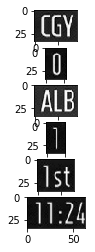

['cgy', '0', 'alb', 't', '1st', '11124']
{'t2_name': 'alb', 't1_score': 0, 't2_score': 1, 'period': 1, 'timer': '11:24', 't1_name': 'cgy'}


In [11]:
from moviepy.editor import VideoFileClip
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../icehockeyaiengine/pipeline')

from scoreboard_analyzer.templates.utils import match_template_and_get_values_common

clip = VideoFileClip('/mnt/disks/d1/s/data/apra/source/albvscgy-icehockey-m-20190209_source.mp4')

timestamp = 2824
image = clip.get_frame(timestamp)
pred_text_arr = detect_scoreboard_pipeline(image, np.asarray([[305, 39, 47, 34], [384, 39, 23, 34], [490, 39, 47, 34], [572, 39, 21, 34], [673, 39, 40, 34], [747, 39, 63, 34]]),ocr_model, ocr_converter, opt )    
scoreboard_values = match_template_and_get_values_common(pred_text_arr)

if len(pred_text_arr) != 0 and scoreboard_values == {} and (pred_text_arr[0] == 'cgy' or pred_text_arr[2] == 'alb'):
    print('Prediction text exists but template match failed <'+str(timestamp)+'>')
    print(pred_text_arr)
# end

print(pred_text_arr)
print(scoreboard_values)


In [ ]:
video_fullpath = '/mnt/disks/d1/s/data/apra/source/50-20190427-game11_source.mp4'
v=cv2.VideoCapture(video_fullpath)
i_offset_in_secs = 3178
v.set(cv2.CAP_PROP_POS_MSEC, i_offset_in_secs*1000)
ret, image = v.read()    
plt.imshow(image)
plt.show()
detect_scoreboard_pipeline(image, np.asarray([[312, 26, 90, 22], [504, 28, 18, 20], [620, 28, 54, 20], [810, 28, 20, 20], [874, 30, 42, 20], [944, 28, 74, 22]]), ocr_model, ocr_converter, opt)
# detect_scoreboard_pipeline(image, np.asarray([[312, 26, 90, 22], [504, 28, 18, 20], [620, 28, 54, 20], [814, 32, 10, 14], [874, 30, 42, 20], [944, 28, 74, 22]]), ocr_model, ocr_converter, opt)

In [ ]:
video_fullpath = '/mnt/disks/d1/s/data/apra/source/15-20190407-game12_source.mp4'
t1_name = 'WAIN'
t2_name = 'ADR'

# net = init_craft()
# ocr_model, ocr_converter = init_ocr(opt)

v=cv2.VideoCapture(video_fullpath)

i_counter = 0
i_offset_in_secs = 350 # offset in seconds 
i_match_counter = 0

pos_sec_arr = []
pos_arr = []

t1_min_box = [[10000 ,  10000],
       [10000 ,  10000],
       [10000  ,  10000 ],
       [10000 ,  10000 ]]

t2_min_box = [[10000 ,  10000],
       [10000 ,  10000],
       [10000  ,  10000 ],
       [10000 ,  10000 ]]

t1_max_box = [[0 ,  0],
       [0 ,  0],
       [0  ,  0 ],
       [0 ,  0 ]]

t2_max_box = [[0 ,  0],
       [0 ,  0],
       [0  ,  0 ],
       [0 ,  0 ]]


while True:
    i_counter += 1
    v.set(cv2.CAP_PROP_POS_MSEC, i_offset_in_secs*1000)
    ret, frame = v.read()    
    if ret != True:
        break
    # end
    
    img_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    matched_out = process_image(frame, t1_name, t2_name)
    
    if 't1' in matched_out and 't2' in matched_out:
        i_match_counter += 1
        pos_arr.append(matched_out)
        pos_sec_arr.append(i_offset_in_secs)
        
        for pt_index, px_pnt in enumerate(matched_out['t1']):
            for xy_index, val in enumerate(px_pnt):
                if t1_min_box[pt_index][xy_index] > val:
                    t1_min_box[pt_index][xy_index] = val
                # end
                if t1_max_box[pt_index][xy_index] < val:
                    t1_max_box[pt_index][xy_index] = val
                # end
            # end            
        # end
        
        for pt_index, px_pnt in enumerate(matched_out['t2']):
            for xy_index, val in enumerate(px_pnt):
                if t2_min_box[pt_index][xy_index] > val:
                    t2_min_box[pt_index][xy_index] = val
                # end
                if t2_max_box[pt_index][xy_index] < val:
                    t2_max_box[pt_index][xy_index] = val
                # end
            # end            
        # end
        
    # end
    
    if i_match_counter == no_of_matches_required_for_team_names:
        break
    # end        
    
    if i_counter % i_print_frequency == 0:
        print('processed<', i_counter, '> offset<', i_offset_in_secs, '> matched<', i_match_counter, '>')
    # end
    
    i_offset_in_secs += skip_delta_in_secs    
# end

print('Completed. Processed<', i_counter, '> offset<', i_offset_in_secs, '>')

i_deviated_error_counter = 0

for pt_index, px_pnt in enumerate(t2_min_box):
    for xy_index, val in enumerate(px_pnt):
        delta_pos = t2_max_box[pt_index][xy_index] - val
        if delta_pos > max_pos_error:
            i_deviated_error_counter += 1
        # end
    # end            
# end

for pt_index, px_pnt in enumerate(t1_min_box):
    for xy_index, val in enumerate(px_pnt):
        delta_pos = t1_max_box[pt_index][xy_index] - val
        if delta_pos > max_pos_error:
            i_deviated_error_counter += 1
        # end
    # end            
# end

print('Deviation Counter<', i_deviated_error_counter, '>')

In [ ]:
pos_arr[0]['t1']

In [ ]:
pos_arr[1]['t1']

In [ ]:
pos_arr[11]['t1']

In [ ]:
pos_sec_arr[0]

In [ ]:
def RepresentsIntTemp(s):
    try: 
        int(s)
        return True
    except ValueError:
        if s == 'o':
            return True
        # end
        return False
    # end
# end

def GetInt(s):
    try: 
        val = int(s)
        return val
    except ValueError:
        if s == 'o':
            return 0
        # end
        return -1
    # end
# end

# 15-20190407-game12 50-20190427-game11
video_fullpath = '/mnt/disks/d1/s/data/apra/source/15-20190407-game12_source.mp4'   
t1_name = 'wain'
t2_name = 'adr'

# net = init_craft()
# ocr_model, ocr_converter = init_ocr(opt)

v=cv2.VideoCapture(video_fullpath)

i_counter = 0
i_offset_in_secs = 480 # offset in seconds 
i_match_counter = 0

missed_secs_arr = []

# b1 = np.array([[495, 23], [527, 23], [527, 55], [495, 55]]) # 492 32 40 40
# b2 = np.array([[801, 23], [832, 23], [832, 55], [801, 55]]) # 746 32 40 40
b1 = np.array([[492, 32], [532, 32], [532, 72], [492, 72]]) # 492 32 40 40
b2 = np.array([[746, 32], [786, 32], [786, 72], [746, 72]]) # 746 32 40 40


cur_score_index = -1
score1_arr= []
score2_arr = []


while True:
    i_counter += 1
    v.set(cv2.CAP_PROP_POS_MSEC, i_offset_in_secs*1000)
    ret, frame = v.read()    
    if ret != True:
        break
    # end
    
    img_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # pred_text_arr = detect_scoreboard(frame, [pos_arr[0]['t1'], pos_arr[0]['t2']])
    pred_text_arr = detect_scoreboard(frame, [b1, b2])
    # print(pred_text_arr)
 
    b_matched = True
    if len(pred_text_arr) != 2 or RepresentsIntTemp(pred_text_arr[0]) == False or RepresentsIntTemp(pred_text_arr[1]) == False:
        b_matched = False
    # end
                   
    if b_matched:
        i_match_counter += 1
        score1 = GetInt(pred_text_arr[0])
        score2 = GetInt(pred_text_arr[1])
        
        if cur_score_index == -1:
            score1_arr.append(score1)
            score2_arr.append(score2)
            cur_score_index += 1     
            cv2.imwrite('scorechanges/'+ filename.split('_source')[0] + '_'+str(i_offset_in_secs).zfill(10)+'.jpg', frame)
        # end
        
        if score1_arr[cur_score_index] != score1 or score2_arr[cur_score_index] != score2:
            score1_arr.append(score1)
            score2_arr.append(score2)
            cur_score_index += 1   
            cv2.imwrite('scorechanges/'+ filename.split('_source')[0] + '_'+str(i_offset_in_secs).zfill(10)+'.jpg', frame)
            print('Score Changed. <', score1, '> <', score2, '>')
        # end        
    else:
        missed_secs_arr.append(i_offset_in_secs)        
        cv2.imwrite('tempcandelete/frame_'+str(i_offset_in_secs).zfill(10)+'.jpg', frame)
    # end
            
    if i_counter % i_print_frequency == 0:
        print('processed<', i_counter, '> offset<', i_offset_in_secs, '> matched<', i_match_counter, '> missed<', len(missed_secs_arr), '>')
    # end
    
    if i_counter > 1000000:
        break
    # end
    
    i_offset_in_secs += 10    
# end

print('Completed. Processed<', i_counter, '> offset<', i_offset_in_secs, '> matched<', i_match_counter, '> missed<', len(missed_secs_arr), '>')
print(score1_arr)
print(score2_arr)

In [ ]:
missed_secs_arr

In [ ]:
video_folder = '/mnt/disks/d1/s/data/apra/source/'
filename = '43-20190425-game4_source.mp4'

hours = 1
minutes = 4
seconds = 41
i_offset_in_secs = hours*60*60 + minutes*60 + seconds

v=cv2.VideoCapture(os.path.join(video_folder, filename))
v.set(cv2.CAP_PROP_POS_MSEC, i_offset_in_secs*1000)
ret, frame = v.read() 
cv2.imwrite('scoreboards/'+ filename.split('_source')[0] + '_'+str(i_offset_in_secs).zfill(10)+'.jpg', frame)

In [ ]:
RepresentsInt('2')